## Airbus sheep detection

### Libraries downloading

In [ ]:
#!pip install opencv-python
#!pip install pydot
#!pip install graphviz
#!pip install segmentation-models

In [ ]:
import pandas as pd

import zipfile

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import shutil
import cv2
import pydot
import graphviz

from sklearn.model_selection import train_test_split

import tensorflow as tf
import datetime

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold

### Data analys

In [ ]:
# Roots with data
data_dir = 'C:/Users/chugu/.kaggle/Airbus_data_for_learning'
train_raw_data = data_dir+'/Airbus_train_raw'
test_raw_data = data_dir + '/airbus_test/Airbus_test_raw'

segmentations = pd.read_csv(data_dir+'/train_ship_segmentations_v2.csv')
test_segmentations = pd.read_csv(data_dir+'/sample_submission_v2.csv')


In [ ]:
test_segmentations['EncodedPixels'].value_counts()
#print(len(test_segmentations))

1 2    15606
Name: EncodedPixels, dtype: int64

In [ ]:
print('Image without ship: ', segmentations['EncodedPixels'].isnull().sum())

Image without ship:  150000


In [ ]:
print('Duplicated images')
print(segmentations['ImageId'].duplicated().value_counts())

Duplicated images
False    192556
True      39167
Name: ImageId, dtype: int64


Dataset ratio

In [ ]:
image_ratio = (len(segmentations)-segmentations['EncodedPixels'].isnull().sum())/len(segmentations)

print('Image without ship: ', segmentations['EncodedPixels'].isnull().sum())
print('Ships/no ships images  ratio: {:.3f}'.format(image_ratio))

Image without ship:  150000
Ships/no ships images  ratio: 0.353


### Data preparation

#### Splitting data

In [ ]:
segmentations['EncodedPixels'].fillna(0, inplace=True)
segmentations.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,0
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [ ]:
ships = segmentations.loc[segmentations[segmentations["EncodedPixels"] != 0].index]
no_ships = segmentations.loc[segmentations[segmentations["EncodedPixels"] == 0].index]
ships["EncodedPixels"] = ships["EncodedPixels"] + " "
print(len(ships))
print(len(no_ships))

81723
150000


In [ ]:
ships = ships.groupby('ImageId').sum()
print(len(ships))

42556


In [ ]:
ships['ImageId'] = ships.index
ships.reset_index(inplace = True, drop = True)
ships.head()

,EncodedPixels,ImageId
0,264661 17 265429 33 266197 33 266965 33 267733...,000155de5.jpg
1,360486 1 361252 4 362019 5 362785 8 363552 10 ...,000194a2d.jpg
2,108287 1 109054 3 109821 4 110588 5 111356 5 1...,00021ddc3.jpg
3,255784 2 256552 4 257319 7 258087 9 258854 12 ...,0002756f7.jpg
4,340363 1 341129 4 341896 6 342663 7 343429 10 ...,00031f145.jpg


In [ ]:
ships = ships.reindex(columns=['ImageId','EncodedPixels'])

encoded_segments = pd.concat([ships, no_ships])
encoded_segments = encoded_segments.sample(frac=1).reset_index(drop=True)
encoded_segments.head()

,ImageId,EncodedPixels
0,914fcbb4a.jpg,0
1,e6bfdb1ae.jpg,0
2,2bc1a5abb.jpg,0
3,ea79b7451.jpg,488853 3 489621 5 490389 5 491157 5 491924 6 4...
4,b77651d09.jpg,0


Data split

In [ ]:
only_ship = encoded_segments[encoded_segments['EncodedPixels']!=0]
only_ship = only_ship[:1000]

In [ ]:
#Train val test datasets
ship_train = encoded_segments[:1000]
ship_val = encoded_segments[1000:1200]
ship_test = encoded_segments[1200:1400]

#### Data preparation for classification

In [ ]:
ship_category = encoded_segments.copy(deep=True)

category = []
for i in ship_category['EncodedPixels']:
  if i == 0:
    category.append(0)
  else:
    category.append(1)  

ship_category['category'] = category
ship_category.head(10)

,ImageId,EncodedPixels,category
0,914fcbb4a.jpg,0,0
1,e6bfdb1ae.jpg,0,0
2,2bc1a5abb.jpg,0,0
3,ea79b7451.jpg,488853 3 489621 5 490389 5 491157 5 491924 6 4...,1
4,b77651d09.jpg,0,0
5,f307642fb.jpg,0,0
6,dbba15b42.jpg,0,0
7,081753306.jpg,0,0
8,db42dd5e7.jpg,0,0
9,644e9cb14.jpg,343689 1 344456 2 345224 1 345991 2 346759 2 3...,1


In [ ]:
ship_category["category"] = ship_category["category"].replace({0: 'no ship', 1: 'ship'}) 
print(len(ship_category))

192556


In [ ]:
only_ship_cat = ship_category[ship_category['EncodedPixels']!=0]
only_no_ship_cat = ship_category[ship_category['EncodedPixels']==0]

category_train = pd.concat([only_ship_cat.head(1000), only_no_ship_cat.head(1000)]).sample(frac=1)
in_max = category_train.index.values.max()

category_val = ship_category[in_max:in_max+600]
category_test = ship_category[in_max+600:in_max+1000]

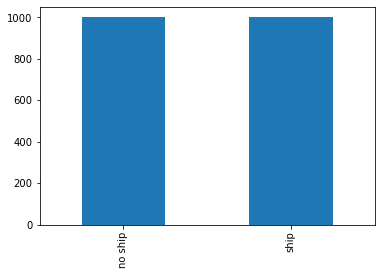

In [ ]:
category_train['category'].value_counts().plot.bar()

#### Keras generators

In [ ]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img

batch_size = 15

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    category_train, 
    train_raw_data, 
    x_col='ImageId',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2000 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    category_val, 
    train_raw_data, 
    x_col='ImageId',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 600 validated image filenames belonging to 2 classes.


Generator test

In [ ]:
example_df = category_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    train_raw_data, 
    x_col='ImageId',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


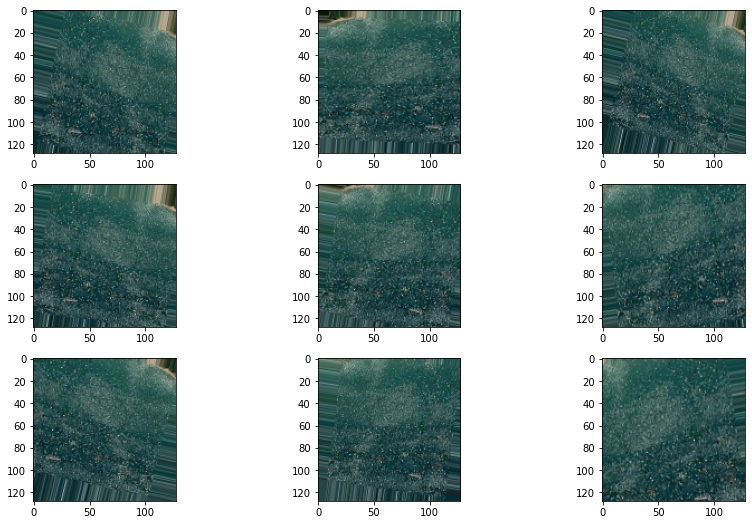

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### Classification model creation

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [ ]:
earlystop = EarlyStopping(patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [ ]:
epochs=5
history = model.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=12,
    steps_per_epoch=100,
    callbacks=callbacks
)

Epoch 1/5
100/100 [==============================] - 65s 627ms/step - loss: 1.3097 - accuracy: 0.5672 - val_loss: 0.9937 - val_accuracy: 0.3000
Epoch 2/5
100/100 [==============================] - 63s 631ms/step - loss: 0.8428 - accuracy: 0.6380 - val_loss: 1.0882 - val_accuracy: 0.2222

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 3/5
100/100 [==============================] - 64s 634ms/step - loss: 0.7763 - accuracy: 0.6357 - val_loss: 0.8236 - val_accuracy: 0.3611
Epoch 4/5
100/100 [==============================] - 63s 630ms/step - loss: 0.8035 - accuracy: 0.6160 - val_loss: 0.7318 - val_accuracy: 0.5111
Epoch 5/5
100/100 [==============================] - 61s 606ms/step - loss: 0.7353 - accuracy: 0.6565 - val_loss: 1.1752 - val_accuracy: 0.3333

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


In [ ]:
model.save_weights("model.h5")

#### Visualazing the learning

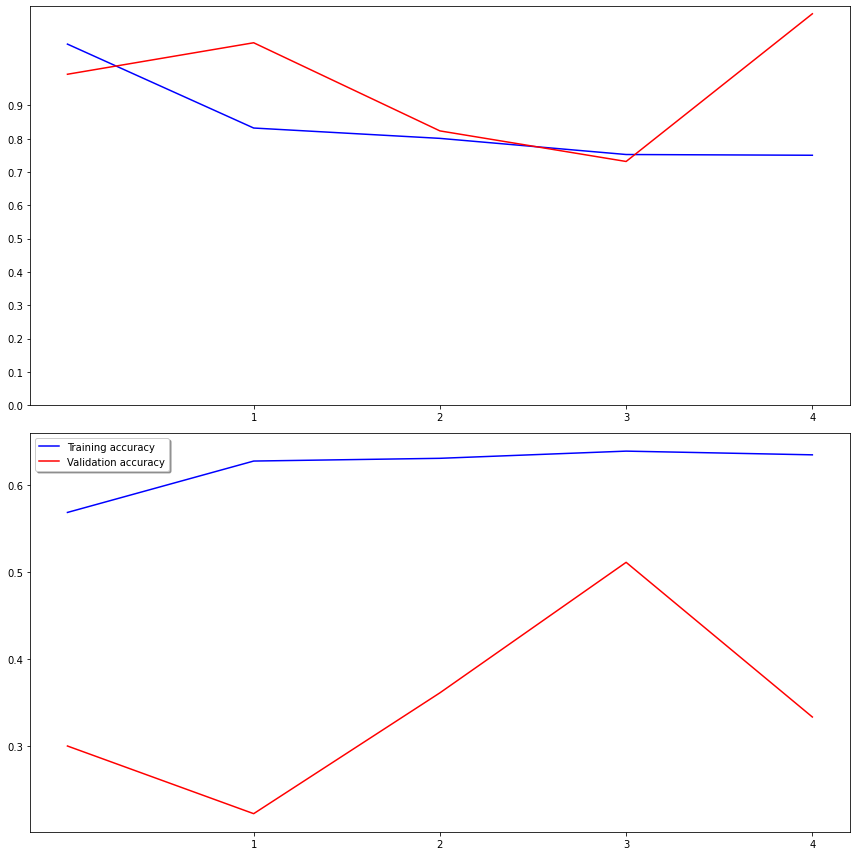

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### Predictions

Test generator

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    category_test, 
    train_raw_data, 
    x_col='ImageId',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


In [ ]:
predict = model.predict(test_generator, steps=np.ceil(len(category_test)/batch_size))

In [ ]:
print(np.argmax(predict, axis=-1))
print(predict.shape)

[1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1
 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1
 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]
(400, 2)


In [ ]:
categories = pd.DataFrame()
categories['ship_or_not'] = pd.Series(np.argmax(predict, axis=-1))
category_test = category_test.reset_index()
categories['ImageId'] = category_test['ImageId']

print(categories.head())
#print(category_test.head())


   ship_or_not        ImageId
0            1  38ce0ffa4.jpg
1            1  c7508ec64.jpg
2            1  47d997f50.jpg
3            1  fb90ba51e.jpg
4            1  984fd4307.jpg


In [ ]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
categories['ship_or_not'] = categories['ship_or_not'].replace(label_map)


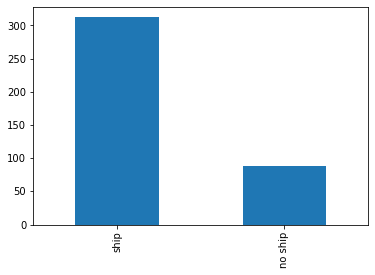

In [ ]:
categories['ship_or_not'].value_counts().plot.bar()

In [ ]:
print(categories.query('ship_or_not == "ship"'))

    ship_or_not        ImageId
0          ship  38ce0ffa4.jpg
1          ship  c7508ec64.jpg
2          ship  47d997f50.jpg
3          ship  fb90ba51e.jpg
4          ship  984fd4307.jpg
..          ...            ...
394        ship  38ecf4954.jpg
395        ship  13a82137d.jpg
396        ship  fcb442145.jpg
398        ship  f9e8b9e94.jpg
399        ship  66dbd9f0b.jpg

[312 rows x 2 columns]


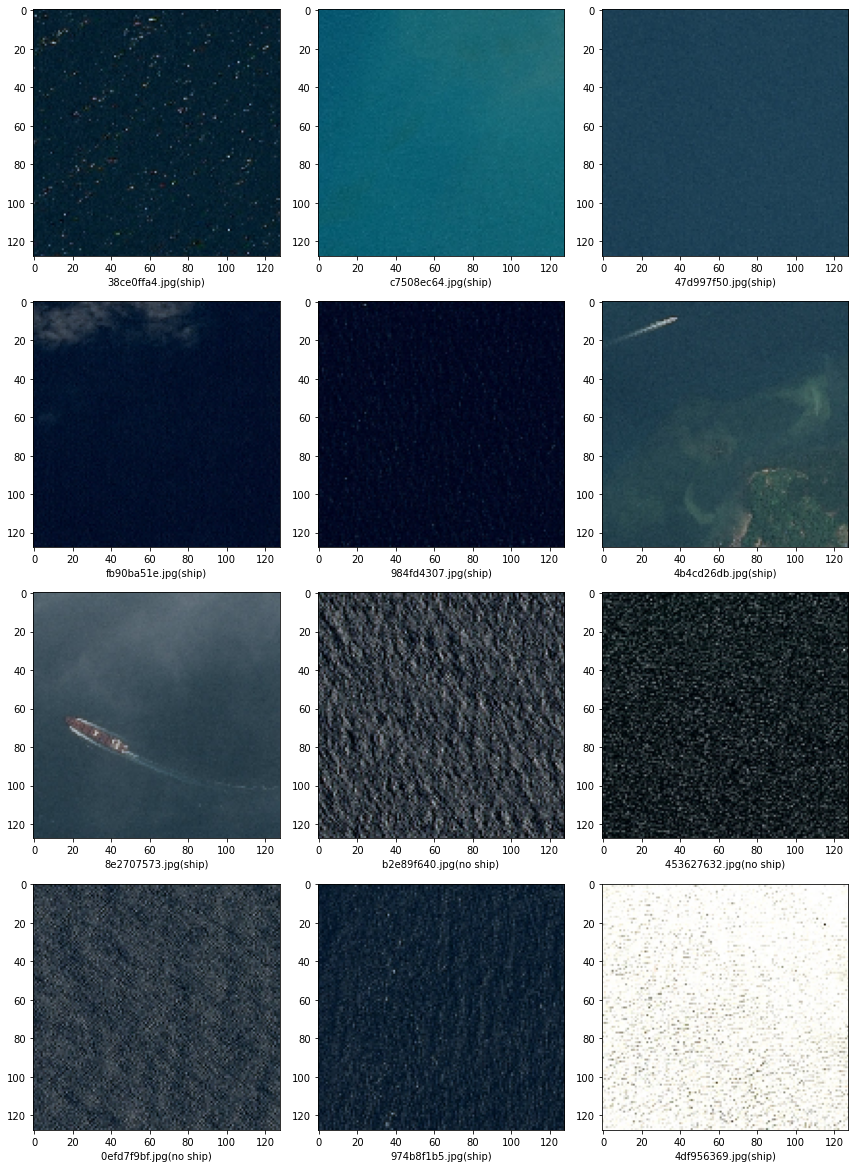

In [ ]:
sample_test = categories.head(12)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['ImageId']
    category = row['ship_or_not']
    img = load_img(train_raw_data+'/'+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()